In [ ]:
# Import modules
from google.colab import files
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
url="https://raw.githubusercontent.com/zhuppyra/price-forecasting/main/Data%20harga%202016-2021%2010%20komoditas.csv"
df=pd.read_csv(url, index_col='Date', parse_dates=True)
df.index.freq='D'
df.head()

,Shallot,Garlic,Rice,Chili pepper,Cayenne pepper,Broiler meat,Topside beef,Granulated sugar,Cooking oil,Chicken egg
Date,,,,,,,,,,
2016-01-01,35774.0,27588.0,10806.0,39831.0,48486.0,33303.0,110235.0,12838.0,15027.0,25743.0
2016-01-02,35068.0,27750.0,10809.0,40191.0,48146.0,33479.0,110265.0,12909.0,15092.0,25774.0
2016-01-03,35318.0,27728.0,10809.0,39581.0,47396.0,33362.0,110338.0,12909.0,15092.0,25700.0
2016-01-04,35757.0,28084.0,10835.0,39251.0,45896.0,34224.0,110306.0,13017.0,14956.0,25564.0
2016-01-05,36236.0,28037.0,10835.0,39241.0,44021.0,34116.0,110245.0,13020.0,14962.0,25586.0


In [ ]:
# checking for missing data
df.isna().any().any()

True

In [ ]:
# filling missing data using last observation carried forward (LOCF)
df1 = df.ffill()
# print dataframe shape
print(df1.shape)
# rechecking for missing data
print(df1.isna().any().any())

(2192, 10)
False


In [ ]:
# only include start of the week/end of week
df1 = df1.iloc[3:]
df1 = df1.iloc[:-5]
print(df1)

            Shallot   Garlic     Rice  Chili pepper  Cayenne pepper  \
Date                                                                  
2016-01-04  35757.0  28084.0  10835.0       39251.0         45896.0   
2016-01-05  36236.0  28037.0  10835.0       39241.0         44021.0   
2016-01-06  36389.0  27879.0  10841.0       38280.0         43209.0   
2016-01-07  36422.0  27990.0  10839.0       37111.0         42636.0   
2016-01-08  36125.0  27925.0  10827.0       35803.0         41440.0   
...             ...      ...      ...           ...             ...   
2021-12-22  28083.0  27859.0  10312.0       51690.0         91394.0   
2021-12-23  28154.0  27898.0  10313.0       51757.0         92519.0   
2021-12-24  28329.0  28068.0  10329.0       51266.0         94845.0   
2021-12-25  28329.0  28068.0  10329.0       51266.0         94845.0   
2021-12-26  28329.0  28068.0  10329.0       51266.0         94845.0   

            Broiler meat  Topside beef  Granulated sugar  Cooking oil  \
Dat

In [ ]:
print(df1.describe())

            Shallot        Garlic          Rice   Chili pepper  \
count   2184.000000   2184.000000   2184.000000    2184.000000   
mean   33308.605311  31554.568223  10573.712454   37079.377289   
std     6671.733968   7130.177343    192.206923    9084.893179   
min    20525.000000  17700.000000   8500.000000   20000.000000   
25%    28321.500000  26734.000000  10479.000000   30645.250000   
50%    32841.000000  29411.500000  10566.000000   34507.000000   
75%    37114.250000  36438.250000  10651.000000   41768.750000   
max    82900.000000  69900.000000  11751.000000  123900.000000   

       Cayenne pepper  Broiler meat   Topside beef  Granulated sugar  \
count     2184.000000   2184.000000    2184.000000       2184.000000   
mean     49696.264194  33304.434066  118777.253663      13403.568681   
std      17684.264109   2277.716259    4412.704624       1264.572248   
min      12000.000000  21700.000000   90000.000000      11500.000000   
25%      37267.250000  31764.250000  116135.0

In [ ]:
# isolate desired commodity
comm_name = 'Broiler meat'
commodity = df1.filter([comm_name])
print(commodity.shape)
commodity.head()

(2184, 1)


,Broiler meat
Date,
2016-01-04,34224.0
2016-01-05,34116.0
2016-01-06,34475.0
2016-01-07,34367.0
2016-01-08,34293.0


In [ ]:
# convert dataframe into numpy array
commodity_ar = np.array(commodity)
print(commodity_ar.shape)
# get the numbers of training data needed
# fitting it to a full week data (hence the +3)
commodity_train_len = int(len(commodity_ar)*.8+3)
commodity_test_len = len(commodity_ar)-commodity_train_len
print(commodity_train_len, commodity_test_len)

(2184, 1)
1750 434


In [ ]:
# scaling the data
scaler=MinMaxScaler(feature_range=(0,1))

In [ ]:
# making training dataset
commodity_train = commodity_ar[0:commodity_train_len]
print(commodity_train.shape)
commodity_train_scaled = scaler.fit_transform(commodity_train)

(1750, 1)


In [ ]:
# creating matrix dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# applying new function to create matrix dataset
time_step = 7
X_train, y_train = create_dataset(commodity_train_scaled, time_step)
print(X_train.shape, y_train.shape)

(1743, 7) (1743,)


In [ ]:
# reshape data
print(X_train.shape), print(y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1743, 7)
(1743,)
(1743, 7, 1)


In [ ]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import GRU
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
neuron = 200
n_epoch = 100

In [ ]:
np.random.seed(333)
tf.random.set_seed(333)

In [ ]:
#Define input layer which has shape (None, 7) and of type float32.
# None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')
# lstm layer
gru_layer1 = GRU(neuron, input_shape=(7,1), return_sequences=True)(input_layer)
gru_layer2 = GRU(neuron, input_shape=(7,neuron), return_sequences=False)(gru_layer1)
#gru_layer3 = GRU(neuron, input_shape=(7,neuron), return_sequences=False)(gru_layer2)
# dropout layer
dropout_layer = Dropout(0.2)(gru_layer2)
# output layer
output_layer = Dense(1)(dropout_layer)
# compile model
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')
ts_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 gru (GRU)                   (None, 7, 200)            121200    
                                                                 
 gru_1 (GRU)                 (None, 200)               240600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 362,001
Trainable params: 362,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ts_model.fit(x=X_train, y=y_train, batch_size=64, epochs=n_epoch, verbose=1,
             shuffle=True)

Epoch 1/100
28/28 [==============================] - 16s 150ms/step - loss: 0.1218
Epoch 2/100
28/28 [==============================] - 3s 116ms/step - loss: 0.0410
Epoch 3/100
28/28 [==============================] - 2s 69ms/step - loss: 0.0355
Epoch 4/100
28/28 [==============================] - 2s 54ms/step - loss: 0.0333
Epoch 5/100
28/28 [==============================] - 1s 53ms/step - loss: 0.0342
Epoch 6/100
28/28 [==============================] - 1s 52ms/step - loss: 0.0341
Epoch 7/100
28/28 [==============================] - 1s 53ms/step - loss: 0.0333
Epoch 8/100
28/28 [==============================] - 1s 52ms/step - loss: 0.0363
Epoch 9/100
28/28 [==============================] - 1s 53ms/step - loss: 0.0349
Epoch 10/100
28/28 [==============================] - 1s 52ms/step - loss: 0.0319
Epoch 11/100
28/28 [==============================] - 2s 54ms/step - loss: 0.0345
Epoch 12/100
28/28 [==============================] - 1s 54ms/step - loss: 0.0365
Epoch 13/100
28/28 [==

In [ ]:
# applying predictin model to training data
train_predict=ts_model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)
print(train_predict[:5])

[[33515.074]
 [34267.87 ]
 [34222.188]
 [34800.758]
 [34741.094]]


In [ ]:
# making testing dataset
commodity_test = commodity_ar[commodity_train_len:]
print(commodity_test.shape)
# normalizing testing dataset
commodity_test_scaled = scaler.transform(commodity_test)
print(commodity_test_scaled[:5])

(434, 1)
[[0.59867278]
 [0.59898878]
 [0.60214884]
 [0.60214884]
 [0.611155  ]]


In [ ]:
# applying new function to create matrix testing data
X_test, y_test = create_dataset(commodity_test_scaled, time_step)
print(X_test.shape, y_test.shape)

(427, 7) (427,)


In [ ]:
# reshaping testing data to fit LSTM model
print(X_test.shape, y_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(427, 7) (427,)
(427, 7, 1)


In [ ]:
# applying prediction model to testing data
test_predict=ts_model.predict(X_test)
# transform to original form
test_predict=scaler.inverse_transform(test_predict)
print(test_predict[:5])

[[33040.793]
 [33542.8  ]
 [33688.613]
 [32818.332]
 [32809.145]]


In [ ]:
# mape calculation
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


commodity_test_data = commodity_ar[len(train_predict)+
                                   (time_step*2):len(commodity_ar)]
commodity_train_data = commodity_ar[time_step:commodity_train_len]
print(commodity_test_data.shape, commodity_train_data.shape)
print('Testing Data Prediction with GRU MAPE score:',
      mape(commodity_test_data, test_predict))
print('Training Data Prediction with GRU MAPE score:',
      mape(commodity_train_data, train_predict))

(427, 1) (1743, 1)
Testing Data Prediction with GRU MAPE score: 0.876875961685979
Training Data Prediction with GRU MAPE score: 1.2155968548873262


In [ ]:
# MAE and MdAE calculation
print('GRU MdAE score:', median_absolute_error(commodity_test_data,
                                                test_predict))
print('GRU MAE score:', mean_absolute_error(commodity_test_data,
                                             test_predict))

GRU MdAE score: 109.212890625
GRU MAE score: 305.7174006513466


In [ ]:
# MSE and RMSE calculation
print('GRU MSE score:', mean_squared_error(commodity_test_data,
                                            test_predict))
print('GRU RMSE score:', mean_squared_error(commodity_test_data,
                                             test_predict, squared=False))

GRU MSE score: 722828.3376156363
GRU RMSE score: 850.1931178359633


In [ ]:
print('GRU MAPE score:',
      mape(commodity_test_data, test_predict))
print('GRU MAE score:', mean_absolute_error(commodity_test_data,
                                             test_predict))

GRU MAPE score: 0.876875961685979
GRU MAE score: 305.7174006513466


In [ ]:
test_predict=pd.DataFrame(test_predict)
test_predict.index=commodity.index[len(train_predict)+
                                   (time_step*2):len(commodity_ar)]

In [ ]:
commodity_test_data=pd.DataFrame(commodity_test_data)
commodity_test_data.index=commodity.index[len(train_predict)+
                                   (time_step*2):len(commodity_ar)]

(array([18561, 18628, 18718, 18809, 18901, 18987]),
 <a list of 6 Text major ticklabel objects>)

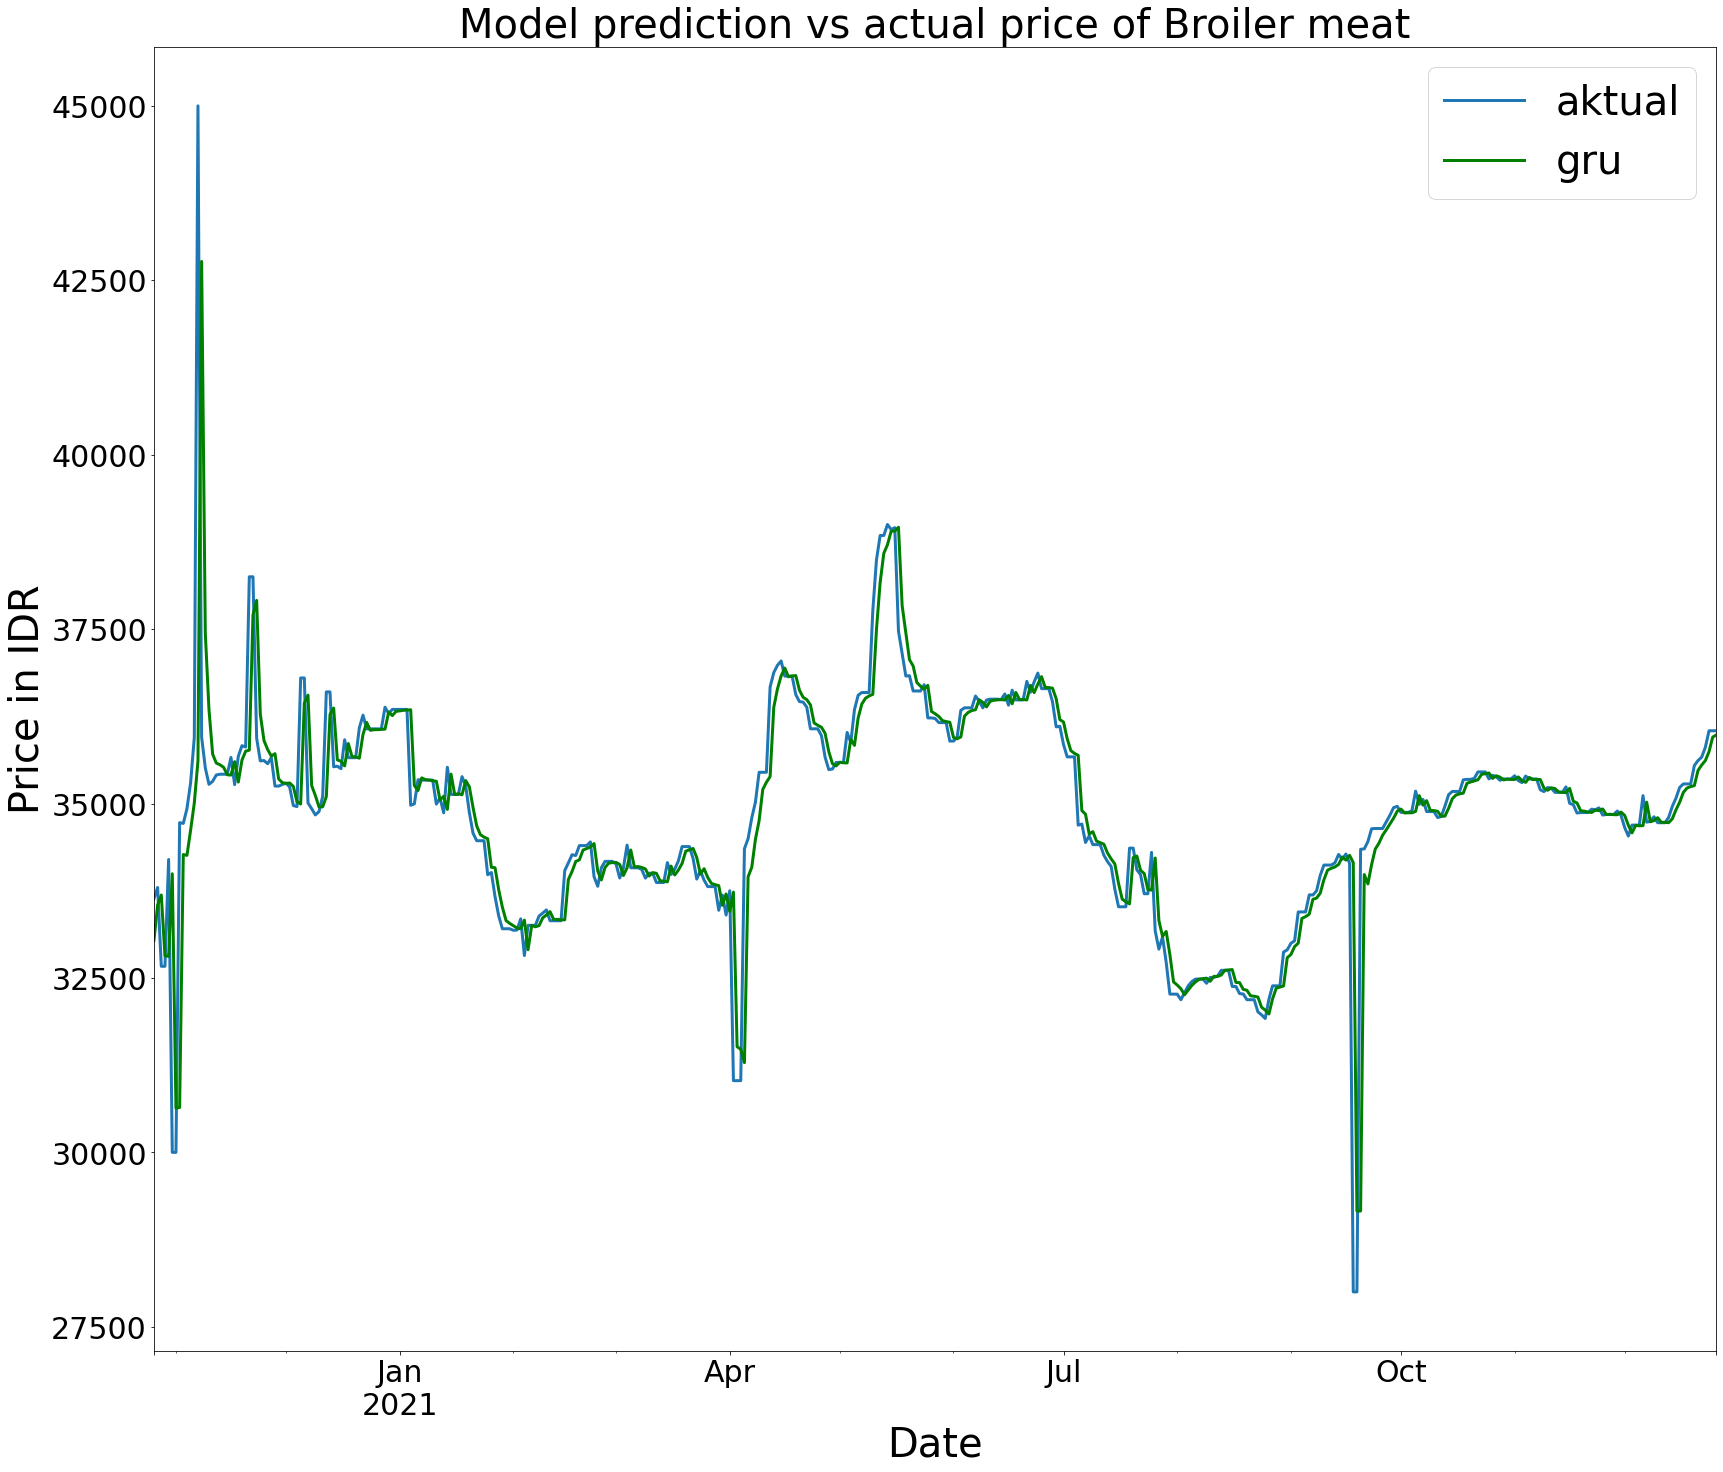

In [ ]:
fig,ax=plt.subplots(figsize=(28,24))
commodity_test_data.plot(ax=ax,linewidth=3)
test_predict.plot(ax=ax,linewidth=3, c='g')
ax.set_title(f'Model prediction vs actual price of {comm_name}',
             size=40)
ax.legend([
           "aktual",
           "gru",
           ],fontsize=40)
ax.set_ylabel('Price in IDR', size=40)
ax.set_xlabel('Date', size=40)
plt.yticks(fontsize=30,)
plt.xticks(fontsize=30,)

In [ ]:
pd.DataFrame(test_predict, columns=[0]).to_csv('revised_gru_broiler meat.csv')
files.download("revised_gru_broiler meat.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>